In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cf = yaml.safe_load(Path('config.yml').read_text())

In [3]:
data = dataloader.load()
dists, labels, words, sem_col_translator = data['dists'],data['labels'],data['words'],data['translator']

In [6]:
# Create a dictionary of day:theta, get stats forr daily theta's, or change for months
dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))} # change to D here for days
stats, mi_arrays = diachronic_linkage(dict_date_theta)
stats = pd.DataFrame(stats)

# Apply Non-Linear Adaptive Filtering to get better signals from the MI mean and std. time series
for col in ['mi_mu','mi_sigma','r_mu','r_sigma','m']:
    stats[col+'_afa'] = adaptive_filter(stats[col])
    
stats['date'] = pd.to_datetime(stats.date.dt.to_timestamp(),infer_datetime_format=True)

100%|██████████| 218/218 [00:02<00:00, 99.14it/s] 


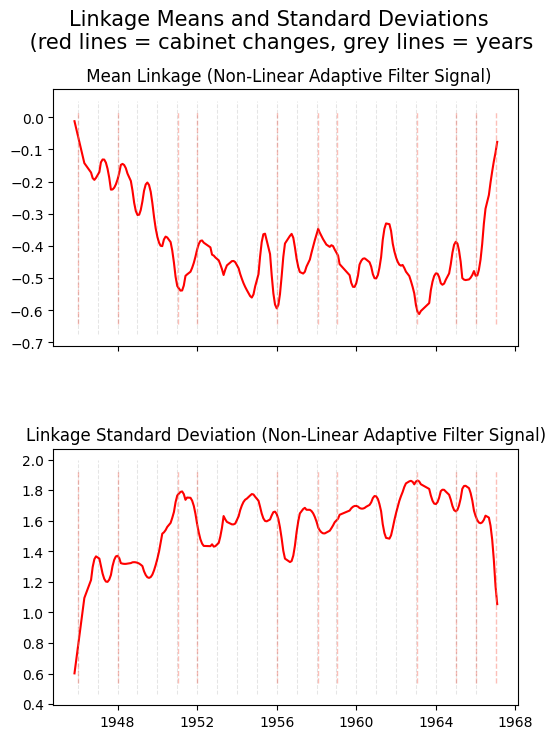

In [7]:
# Plot Month- and Linkage Means and Standard Deviations
fig,ax = plt.subplots(2,1,figsize=(6,8),sharex=True)

ax[0].plot(stats.date,stats.mi_mu_afa,color='red')
ax[0].set_title(' Mean Linkage (Non-Linear Adaptive Filter Signal)',fontsize=12)

ax[1].plot(stats.date,stats.mi_sigma_afa,color='red')
ax[1].set_title('Linkage Standard Deviation (Non-Linear Adaptive Filter Signal)',fontsize=12)

for a in ax.flatten():
    add_cabinet_periods(a,text=False) #change path name here
    a.vlines(x=[f'{y}-01-01' for y in range(1946,1967)], ymin=a.get_ylim()[0], ymax=a.get_ylim()[1], color='k', ls='--',alpha=.1, lw=.75)

plt.subplots_adjust(wspace=.2,hspace=.4)
fig = plt.gcf()
fig.suptitle('Linkage Means and Standard Deviations\n (red lines = cabinet changes, grey lines = years',fontsize=15)
# fig.savefig('figs/linkage-means-stds-day.pdf',dpi=250,bbox_inches='tight')
plt.show()

In [7]:
stats.to_csv('results/linkage-stats-day.csv',index=False,sep='\t')